<a href="https://colab.research.google.com/github/Mahmodtomah/Skin-Cancer/blob/main/SkinCancer1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torchvision.io import read_image

import cv2 as cv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_path = '/content/data/train'
test_path = '/content/data/test'

cpu


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/archive (1).zip"

with ZipFile(file_name,'r') as zips:
  zips.extractall()
  print('Done')

Done


In [ ]:
train_data = torchvision.datasets.ImageFolder(train_path, transform=T.Compose([T.Resize(32)]))
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=None, shuffle=True)

N_samples = 100

sums = 0
sum_sq = 0
for counter, (image, _) in enumerate(train_loader):
    if counter < N_samples:
        img = T.ToTensor()(image)
        sums += torch.sum(img.reshape(3, -1), dim=1)
        sum_sq += torch.sum(img.reshape(3, -1) ** 2, dim=1)
    else:
        break

N = N_samples * torch.numel(img)
mean = sums / N
std = torch.sqrt(sum_sq / N - mean ** 2)

print(f'Mean:{mean} std:{std}')

Mean:tensor([0.2523, 0.1834, 0.1855]) std:tensor([0.3676, 0.2764, 0.2815])


In [ ]:
new_size = (256, 256)
batch_size = 32

# ----- train data
train_transforms = T.Compose([
    T.Resize(new_size),
    T.ToTensor(),
    T.RandomErasing(p=0.5, scale=(0.02, 0.10), ratio=(0.25, 4)),
    T.Normalize(mean=mean, std=std)
])

train_data = torchvision.datasets.ImageFolder(train_path, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
print('Train data loaded!')



# ----- test data
test_transforms = T.Compose([
    T.Resize(new_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

test_data = torchvision.datasets.ImageFolder(test_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
print('Test data loaded!')

Train data loaded!
Test data loaded!


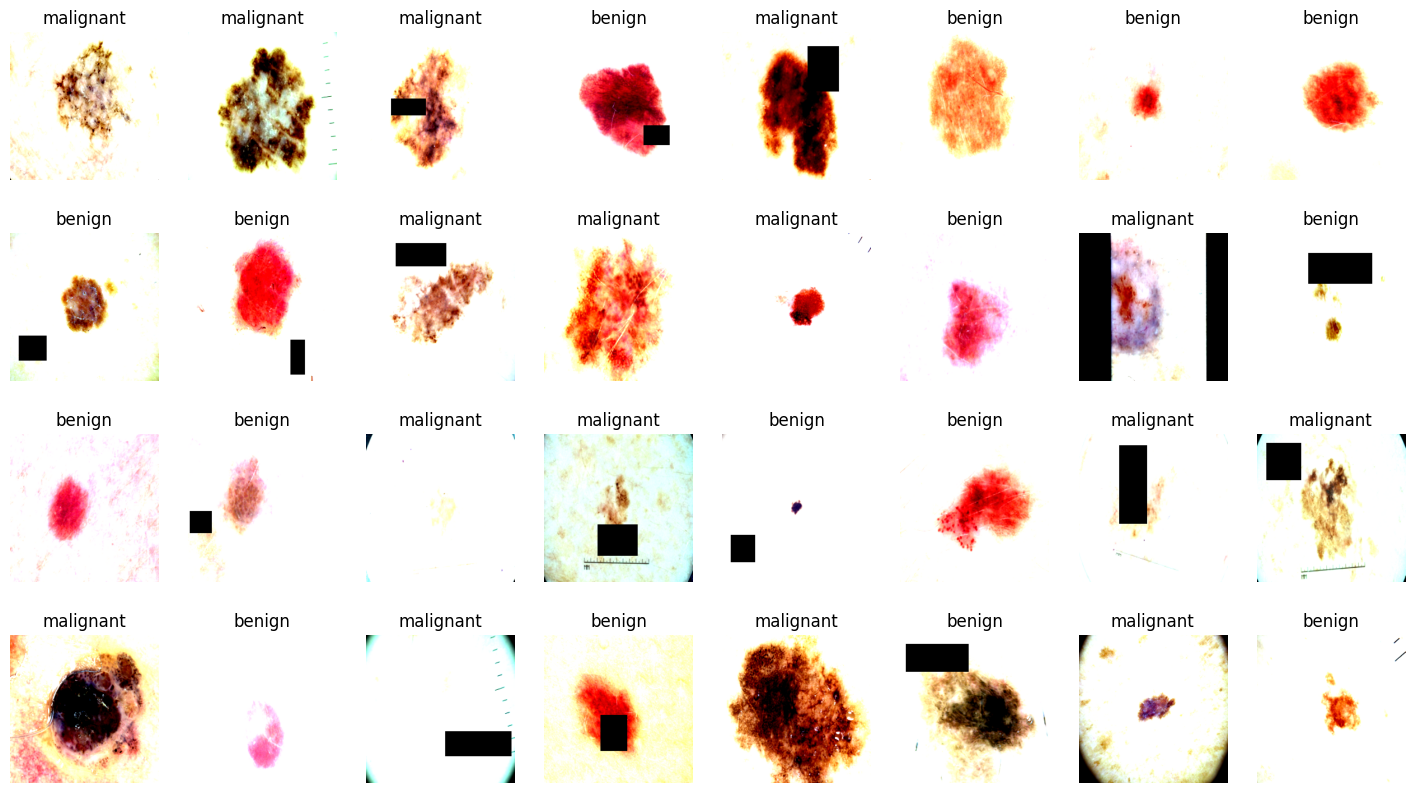

In [ ]:
fig, ax = plt.subplots(4,8, figsize=(18,10))
ax = ax.ravel()

for counter, ind in enumerate( np.random.randint(0,len(train_data), 32) ):
    img, target = train_data[ind]
    img = torch.permute(img, [1, 2, 0])
    ax[counter].imshow(img)
    label = [key for key, val in train_data.class_to_idx.items() if val == target][0]
    ax[counter].set_title(label)
    ax[counter].axis('off')

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding='same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(256 * 8 * 8, 128),
    nn.ReLU(),
    nn.Linear(128, 8),
    nn.ReLU(),
    nn.Linear(8, 2)
)

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=2)

In [ ]:
n_epochs = 20

model.to(device)

train_loss_all = []
test_loss_all = []
Accuracy_all = []
lr_all = []

for epoch in range(n_epochs):
    model.train()

    train_loss = 0
    num_correct = 0
    num_total = 0
    for batch_ind, batch in enumerate(train_loader):
        images = batch[0].to(device)
        targets = batch[1].to(device)

        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(scores, 1)
        num_correct += (predicted == targets).sum().item()
        num_total += targets.size(0)

        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    Accuracy_train = num_correct / num_total * 100

    with torch.no_grad():
        model.eval()

        test_loss = 0
        num_correct = 0
        num_total = 0
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            scores = model(images)
            _, predicted = torch.max(scores, 1)

            loss = criterion(scores, targets)
            test_loss += loss.item()

            num_correct += (predicted == targets).sum().item()
            num_total += targets.size(0)

        test_loss = test_loss / len(test_loader)
        Accuracy_test = num_correct / num_total * 100

    lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_all.append(lr)
    scheduler.step(test_loss)

    Accuracy_all.append( (Accuracy_train, Accuracy_test) )
    train_loss_all.append( train_loss )
    test_loss_all.append( test_loss )
    print(f'[{epoch+1}/{n_epochs}]:\
    Train_error={train_loss:.2f} Test_error={test_loss:.2f} ----------------------\
    Train_Acc={Accuracy_train:0.1f} Test_Acc={Accuracy_test:0.1f} ----------------------\
    Lr:{lr:.8f}')

[1/20]:    Train_error=0.63 Test_error=0.57 ----------------------    Train_Acc=62.3 Test_Acc=80.3 ----------------------    Lr:0.00001000
[2/20]:    Train_error=0.54 Test_error=0.50 ----------------------    Train_Acc=80.5 Test_Acc=82.3 ----------------------    Lr:0.00001000
[3/20]:    Train_error=0.48 Test_error=0.45 ----------------------    Train_Acc=80.7 Test_Acc=82.6 ----------------------    Lr:0.00001000
[4/20]:    Train_error=0.43 Test_error=0.40 ----------------------    Train_Acc=81.6 Test_Acc=83.5 ----------------------    Lr:0.00001000
[5/20]:    Train_error=0.41 Test_error=0.39 ----------------------    Train_Acc=82.6 Test_Acc=82.6 ----------------------    Lr:0.00001000
[6/20]:    Train_error=0.38 Test_error=0.37 ----------------------    Train_Acc=83.0 Test_Acc=83.8 ----------------------    Lr:0.00001000
[7/20]:    Train_error=0.36 Test_error=0.35 ----------------------    Train_Acc=84.5 Test_Acc=84.4 ----------------------    Lr:0.00001000
[8/20]:    Train_error=0.35

Text(0, 0.5, 'Accuracy')

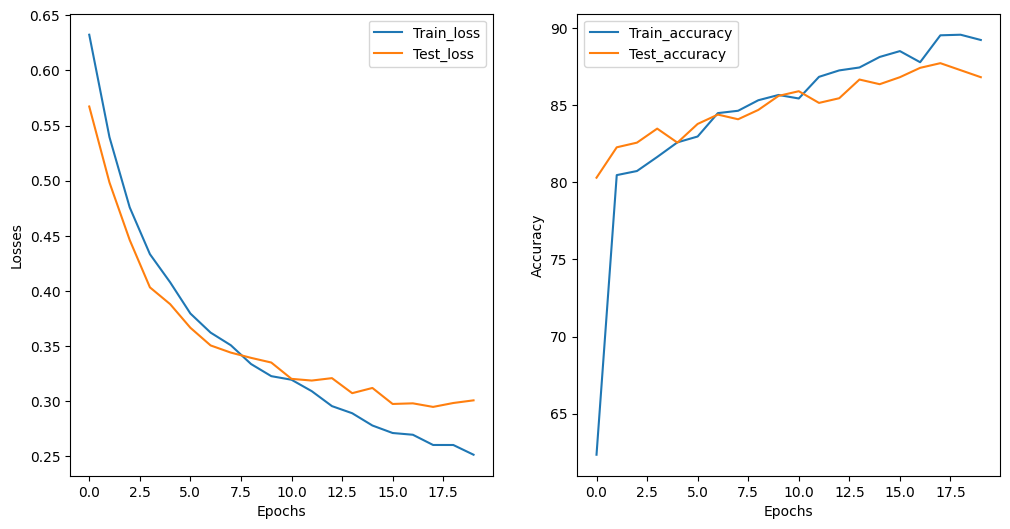

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(np.array(train_loss_all), label='Train_loss')
ax[0].plot(np.array(test_loss_all), label='Test_loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')

ax[1].plot(np.array(Accuracy_all)[:,0], label='Train_accuracy')
ax[1].plot(np.array(Accuracy_all)[:,1], label='Test_accuracy')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

In [ ]:
model_path = '/content/drive/MyDrive/trained_models'


In [ ]:
import os

if not os.path.exists(model_path):
    os.makedirs(model_path)


In [ ]:
torch.save(model, os.path.join(model_path, 'trained_model.pth'))
